# Conditional DE and SBI


In [7]:
import numpy as np
import matplotlib.pyplot as plt

import torch

import sys
sys.path.append('../flows/')

from nf_flows import construct_maf, construct_nsf
from train import train

## Conditional Moons 
https://github.com/bayesiains/nflows/blob/master/examples/conditional_moons.ipynb 

In [4]:
# Load data 
import sklearn.datasets as datasets
x, y = datasets.make_moons(128, noise=.1)
x = torch.FloatTensor(x) # 2D data samples
y = torch.FloatTensor(y).reshape(-1, 1) # Labels (0 or 1)

# Define Flow: MAF or NSF with 1 context feature: labels y (0 or 1)
maf = construct_maf(x, hidden_features=50, context_features=1, standardize_transform=False)
# nsf = construct_nsf(x, hidden_features=50, context_features=1)

# Train Flow 
train(maf, x, context=y, num_epochs=2000, plot=False)

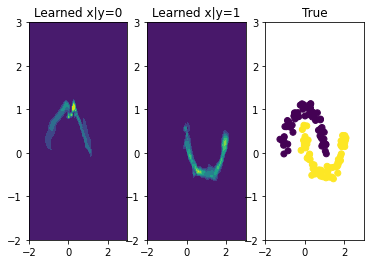

In [5]:
# Plot learned vs true density

plt_min=-2
plt_max=3

fig, ax = plt.subplots(1, 3)
xline = torch.linspace(plt_min, plt_max)
yline = torch.linspace(plt_min, plt_max)
xgrid, ygrid = torch.meshgrid(xline, yline)
xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

with torch.no_grad():
    zgrid0 = maf.log_prob(xyinput, torch.zeros(10000, 1)).exp().reshape(100, 100)
    zgrid1 = maf.log_prob(xyinput, torch.ones(10000, 1)).exp().reshape(100, 100)

ax[0].contourf(xgrid.numpy(), ygrid.numpy(), zgrid0.numpy())
ax[0].set_xlim(left=plt_min, right=plt_max)
ax[0].set_ylim(bottom=plt_min, top=plt_max)
ax[0].set_title('Learned x|y=0')

ax[1].contourf(xgrid.numpy(), ygrid.numpy(), zgrid1.numpy())
ax[1].set_xlim(left=plt_min, right=plt_max)
ax[1].set_ylim(bottom=plt_min, top=plt_max)
ax[1].set_title('Learned x|y=1')

ax[2].scatter(x[:,0], x[:,1], c=y)
ax[2].set_xlim(left=plt_min, right=plt_max)
ax[2].set_ylim(bottom=plt_min, top=plt_max)
ax[2].set_title('True')
plt.show()

#### Questions:
- conditional base dist? 
- embedding net for context?
- standardize for context?

## SBI toy example in 1D
https://github.com/mlcolab/sbi-workshop/blob/main/slides/2_1_cde.ipynb

### Simulator and training data
The simulated data is defined by: 

$x=\theta + 0.3\sin(2\pi\theta)+\epsilon$

We will try to estimate $p(\theta|x)$ given samples $x_i$ simulated from the uniformly drawn prior samples $\theta_i$.

In [105]:
# generate data
n = 4000  # number of datapoints
d = 1  # dimensionality of parameters theta

theta = torch.rand((n, d))  # Prior samples

noise = torch.randn((n, d)) * 0.05
x = theta + 0.3*torch.sin(2*np.pi*theta) + noise  # Simulated samples

theta_eval = torch.tensor([0.6])  # Value for conditional inference

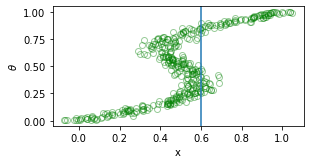

In [93]:
# Data theta_train and x_train
fig = plt.figure(figsize=(4.5, 2.2))
plt.plot(x[:400], theta[:400], 'go', alpha=0.4, markerfacecolor='none')
plt.axvline(val_to_eval.numpy())
plt.ylabel(r'$\theta$')
plt.xlabel('x')
plt.show()

### MAF - affine transformations

In [94]:
# Define Flow
maf = construct_maf(theta, hidden_features=50, context_features=1, standardize_transform=False)

# Train Flow 
train(maf, theta, context=x, num_epochs=100, plot=False)

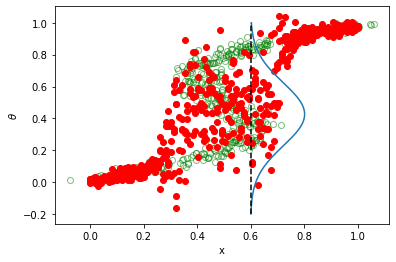

In [117]:
# Plot samples from true vs learned distribution
x_test = torch.linspace(0.0, 1.0, 100).unsqueeze(1)
theta_samples = maf.sample(5, context=x_test)

plt.plot(x[:400], theta[:400], 'go', alpha=0.5, markerfacecolor='none')
plt.plot(x_test, theta_samples.squeeze().detach(), 'ro', linewidth=3.0)
plt.ylabel(r'$\theta$')
plt.xlabel('x')

# Plot learned conditional distribution
x_vals = torch.linspace(-0.2, 1.0, 1000).reshape(-1,1)
y_vals = maf.log_prob(x_vals, context=torch.ones(1000,1)*theta_eval).exp()
x_vals = x_vals.numpy()
y_vals = y_vals.detach().numpy()

plt.plot(y_vals*0.1+theta_eval.item(), x_vals)
plt.plot(list(theta_eval)*1000, x_vals, linestyle="--", color="k")
plt.show()



MAF flow not working: doesn't capture the non-gaussian target distribution.

### NSF - spline transformations

In [70]:
from sbi.neural_nets.flow import build_nsf  # their version handles the 1D case
nsf = build_nsf(batch_x=theta, batch_y=x, num_transforms=1) # In 1D multiple trnasform layers do not increase performance 
train(nsf, theta, context=x, num_epochs=100, plot=False)

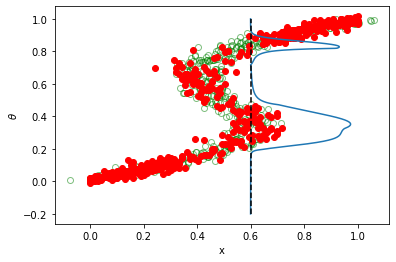

In [118]:
# Plot samples from true vs learned distribution
x_test = torch.linspace(0.0, 1.0, 100).unsqueeze(1)
theta_samples = nsf.sample(5, context=x_test)

plt.plot(x[:400], theta[:400], 'go', alpha=0.5, markerfacecolor='none')
plt.plot(x_test, theta_samples.squeeze().detach(), 'ro', linewidth=3.0)
plt.ylabel(r'$\theta$')
plt.xlabel('x')

# Plot learned conditional distribution
x_vals = torch.linspace(-0.2, 1.0, 1000).reshape(-1,1)
y_vals = nsf.log_prob(x_vals, context=torch.ones(1000,1)*theta_eval).exp()
x_vals = x_vals.numpy()
y_vals = y_vals.detach().numpy()

plt.plot(y_vals*0.1+theta_eval.item(), x_vals)
plt.plot(list(theta_eval)*1000, x_vals, linestyle="--", color="k")
plt.show()



In 1D the number of transformation layers, autoregressive models and permutations do not matter: there are no covariates to consition on or to permute, an affine transformation will thus conserve the gaussian nature of the distribution. Spline transformations however will capture the different modes of the target distribution (here $p(\theta|x)$). 

#### Questions:
- maf with conditional base dist ? 
- embedded context? 
- more than 1D?


## Lodka-Volterra Simulator: SBI toy example on time series in 2D
https://github.com/mlcolab/sbi-workshop/blob/main/slides/2_2_snpe.ipynb

### Simulator and Observation
The Lodka-Volterra simulator is a model that describes the evolution of the population of two species (e.g. foxes and rabbits):

$ \frac{du}{dt} = au - buv + \epsilon$

$ \frac{dv}{dt} = -cv + dbuv + \epsilon$


| a   | prey reproduction rate |

| b   | prey death rate per predator |

| c   | predator death rate (if no prey) |

| d   | predators born per prey |

| u   | prey / rabbits

| v   | predator / foxes

$\epsilon$ is Gaussian noise.

Code taken from: https://scipy-cookbook.readthedocs.io/items/LoktaVolterraTutorial.html

Text(0.5, 1.0, 'Evolution of fox and rabbit populations')

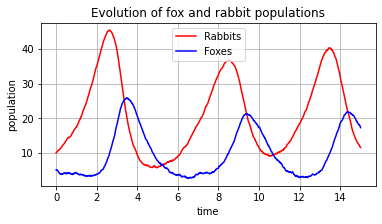

In [146]:
# Define simulator and generate observation

import sdeint 

t = np.linspace(0, 15, 1000)      # time
X0 = np.array([10.0, 5.0])        # initials conditions: 10 rabbits and 5 foxes

def run_model(theta, X0=X0, t=t):
    a = theta[0]
    b = theta[1]
    c = 1.5
    d = 0.75
    
    def dX_dt(X, t):
        return np.array([ a*X[0] -   b*X[0]*X[1] ,
                      -c*X[1] + d*b*X[0]*X[1] ])
    def dW(x, t):
        return 0.7 * np.eye(2)  # Gaussian noise

    X = sdeint.itoint(dX_dt, dW, X0, t)
    return X

theta_true = [1.0, 0.1]  # parameters (a, b)
X_obs = run_model(theta_true)  # simulated observation 

# Plot observation
rabbits, foxes = X_obs.T
f1 = plt.subplots(1, 1, figsize=(6, 3))
plt.plot(t, rabbits, 'r-', label='Rabbits')
plt.plot(t, foxes  , 'b-', label='Foxes')
plt.grid()
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('population')
plt.title('Evolution of fox and rabbit populations')

### Training data

In [128]:
# Prior 
from sbi.utils import BoxUniform
lower_bound = [0.5, 0.0]
upper_bound = [3.5, 0.5]
prior = BoxUniform(lower_bound, upper_bound)

In [147]:
# Sum-Stats
def summstats(trace):
    rabbits_mean = [np.mean(trace[:, 0])]
    foxes_mean = [np.mean(trace[:, 1])]
    rabbits_variance = [np.var(trace[:, 0])]
    foxes_variance = [np.var(trace[:, 1])]
    autocorr_rabbits1 = [np.correlate(trace[:, 0], trace[:, 0], "full")[100]]
    autocorr_rabbits2 = [np.correlate(trace[:, 0], trace[:, 0], "full")[200]]
    autocorr_foxes1 = [np.correlate(trace[:, 1], trace[:, 1], "full")[100]]
    autocorr_foxes2 = [np.correlate(trace[:, 1], trace[:, 1], "full")[200]]
    cross_corr = np.correlate(trace[:, 0], trace[:, 1])
    
    summ_stats = np.concatenate(
        [
            rabbits_mean, foxes_mean, rabbits_variance, foxes_variance, 
            autocorr_rabbits1, autocorr_rabbits2, 
            autocorr_foxes1, autocorr_foxes2, cross_corr
        ]
    )
    return summ_stats

In [225]:
# Training data from simulator 
N = 500  # number of simulations

thetas = prior.sample((N,))
xs = []
for theta in thetas:
    trace = run_model(theta)
    summ_stats = summstats(trace)
    xs.append(summ_stats)
xs = np.stack(xs)


### Preprocessing the training data

In [226]:
# Exclude NaNs
contains_no_nan = np.invert(np.any(np.isnan(xs), axis=1))
thetas_train = thetas[contains_no_nan]
xs_train = xs[contains_no_nan]

# Exclude large values 
contains_no_inf = np.invert(np.any(xs_train < -1e6, axis=1))
thetas_train = thetas_train[contains_no_inf]
xs_train = xs_train[contains_no_inf]

contains_no_inf = np.invert(np.any(xs_train > 1e6, axis=1))
thetas_train = thetas_train[contains_no_inf]
xs_train = xs_train[contains_no_inf]

# Standardize the data (z-score)
thetas_torch = torch.as_tensor(thetas_train, dtype=torch.float32)
xs_torch = torch.as_tensor(xs_train, dtype=torch.float32)

xs_mean = torch.mean(xs_torch, dim=0)
xs_std = torch.std(xs_torch, dim=0)
xs_zscored = (xs_torch - xs_mean) / xs_std

theta_mean = torch.mean(thetas_torch, dim=0)
theta_std = torch.std(thetas_torch, dim=0)
theta_zscored = (thetas_torch - theta_mean) / theta_std

### Train MAF

In [238]:
# Define Flow
maf = construct_maf(theta_zscored, hidden_features=50, context_features=9, standardize_transform=False)

# Train Flow
train(maf, theta_zscored, context=xs_zscored, num_epochs=500, plot=False)

### Evaluate MAF

In [250]:
# Preprocess observation 
theta_true = [1., 0.1]
X_obs = run_model(theta_true)
xo = summstats(X_obs)
xo = torch.as_tensor(xo, dtype=torch.float32)
xo_zscored = (xo - xs_mean) / xs_std
xo_torch = torch.as_tensor(xo_zscored, dtype=torch.float32).unsqueeze(0)


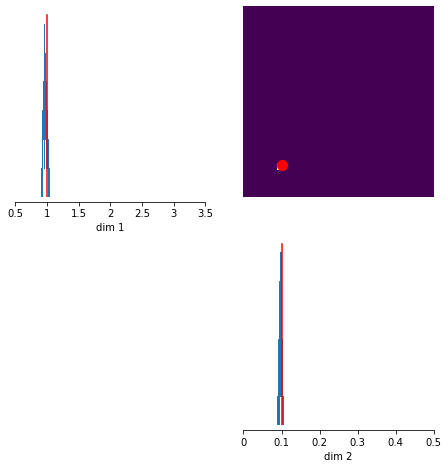

In [251]:
# Plot posterior samples / distribution
from sbi.analysis import pairplot
theta_samples = maf.sample(100, context=xo_torch).detach().numpy()[0]
theta_samples = theta_samples*theta_std.numpy() + theta_mean.numpy()  # De-standardize data 
_ = pairplot(theta_samples, limits=[[0.5, 3.5], [0.0, 0.5]], points=[theta_true], figsize=(7.5, 7.5), points_colors="r")

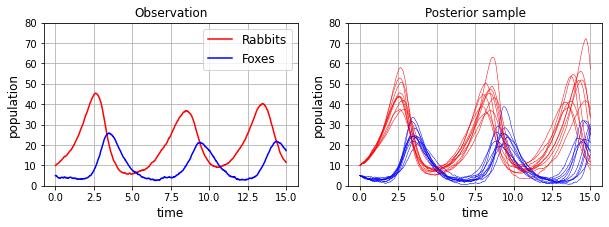

In [252]:
# Plot posterior simulations 
posterior_simulation = [run_model(theta_samples[i]).T for i in range(10)]
rabbits_sim = [pair[0] for pair in posterior_simulation]
foxes_sim = [pair[1] for pair in posterior_simulation]

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(t, rabbits, 'r-', label='Rabbits')
ax[0].plot(t, foxes, 'b-', label='Foxes')
ax[0].grid()
ax[0].legend(loc='upper right', fontsize=12.)
ax[0].set_xlabel('time', fontsize=12.)
ax[0].set_ylabel('population', fontsize=12.)
ax[0].set_title("Observation", fontsize=12.)
ax[0].set_ylim([0, 80])

for i in range(10):
    ax[1].plot(t, rabbits_sim[i], 'r-', label='Rabbits', lw=0.5)
    ax[1].plot(t, foxes_sim[i], 'b-', label='Foxes', lw=0.5)
ax[1].grid()
ax[1].set_xlabel('time', fontsize=12.)
ax[1].set_ylabel('population', fontsize=12.)
ax[1].set_title("Posterior sample", fontsize=12.)
ax[1].set_ylim([0, 80])
plt.show()


No need to try NSF, as MAF is already working well. The number of training samples is crucial for exact posterior estimation: 50 not enough, 500 better, 5000 works very well (exact mean and less variance) but simulating this many samples is slow. As the number of training epochs increases, the result is even more exact (can compensate for fewer training samples).